In [3]:
import implementations
import pandas as pd
import numpy as np
import helpers
import preprocessing


In [4]:
datapath_train = "./dataset/"
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data(datapath_train)
data_path_names = "./dataset/x_train.csv"
feature_names = np.genfromtxt(data_path_names, max_rows=2, delimiter=",", names=True).dtype.names
feature_names = feature_names[1:]  
columns = np.asarray(feature_names[0:])

In [5]:
%reload_ext autoreload
%autoreload 2
import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *
from metrics import *

In [6]:
x_train_preprocess, x_test_preprocess, y_train = preprocessing.dataPreprocess(x_train, x_test, y_train, columns, feature_names)
x_train_preprocess.shape,x_test_preprocess.shape 

/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


((328135, 582), (109379, 582))

In [14]:
import cross_validation as cv
import metrics
import matplotlib.pyplot as plt


subset_size = 10000

# print(x_new_del_train.shape)
# print(y_train.shape)

# Generate random indices to select data points for the subset
indices = np.random.choice(len(x_train), subset_size, replace=False)

# Create the random subset from x_train and y_train
x_cv = x_train_preprocess[indices]
y_cv = y_train[indices]


x_cv.shape,y_cv.shape


((10000, 582), (10000,))

In [15]:
def plot_confusion_matrix(actual_y, pred_y, title):
    tp, tn, fp, fn = metrics.calculate_parameters(pred_y, actual_y)
    # Create a confusion matrix plot
    confusion_matrix = [[tn, fp], [fn, tp]]

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    plt.xticks([0, 1], ["Predicted (-1)", "Predicted (1)"])
    plt.yticks([0, 1], ["Real value is (-1)", "Real value is (1)"])

    for i in range(2):
        for j in range(2):
            cell_value = confusion_matrix[i][j]
            text_color = 'white' if cell_value > 50000 else 'black'  # Adjust the threshold as needed
            plt.text(j, i, str(confusion_matrix[i][j]), ha='center', va='center', color=text_color, fontsize=16)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)

    plt.show()

In [28]:
best_gamma, best_max_iters = cv.cross_validation_linear_regression(y_cv, x_cv, sgd=False, k=5, threshold=0, max_iters_list=[1000], gamma_list=[0.01])

Best gamma value is 0.01
Best max_iters value is 1000
________________________
Average F1 score: 12.59 %
Average accuracy: 71.59 %
________________________


________________________
The average F1 score: 14.40 %
The average accuracy: 91.66 %
________________________


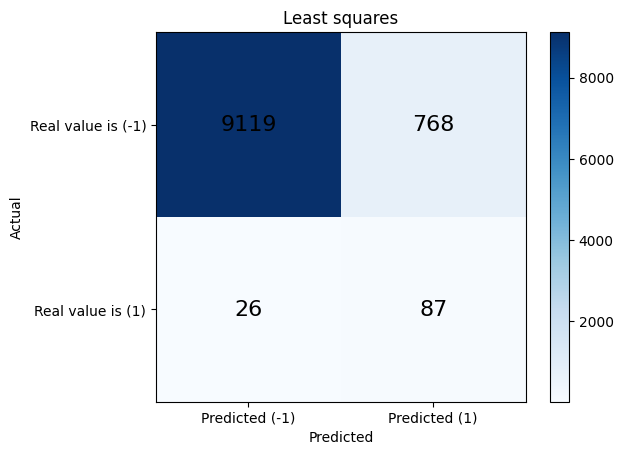

In [17]:
# Least squares
# With k=30 and subset_size=200 000, best F1 score = 11.75%
cv.cross_validation_least_squares(y_cv, x_cv)

w, _ = implementations.least_squares(y_cv, x_cv)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)    

plot_confusion_matrix(y_cv, pred_discrete, "Least squares")

Best lambda value is 1e-15
________________________
Average F1 score: 14.40 %
Average accuracy: 91.66 %
________________________


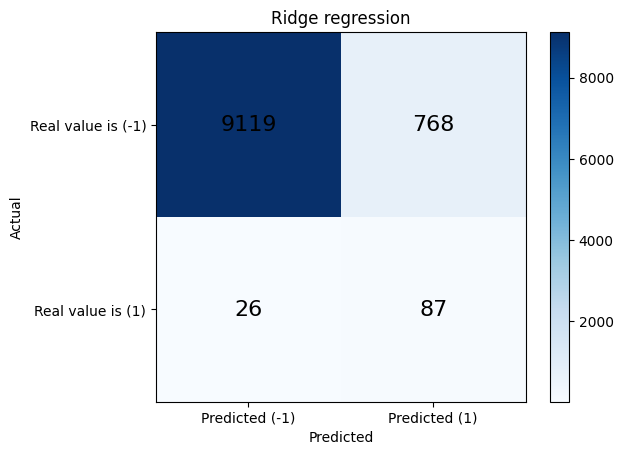

In [19]:
# Ridge regression
# Best lambda = 0.0011
min_lambda = 0.000000001
max_lambda = 1.0
step_size = 0.01

#lambda_values = [min_lambda + step_size * i for i in range(int((max_lambda - min_lambda) / step_size) + 1)]

best_lambda = cv.cross_validation_ridge_regression(y_cv, x_cv, lambda_values=[1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10])

w, _ = implementations.ridge_regression(y_cv, x_cv, best_lambda)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)

plot_confusion_matrix(y_cv, pred_discrete, "Ridge regression")



In [20]:
# Logistic regression
cv.cross_validation_logistic(y_cv, x_cv)

Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.658549713677132
Current iteration==0, loss=-28.61537624318349
Current iteration==0, loss=-28.520394608097487
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.658549713677132
Current iteration==0, loss=-28.61537624318349
Current iteration==0, loss=-28.520394608097487
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.658549713677132
Current iteration==0, loss=-28.61537624318349
Current iteration==0, loss=-28.520394608097487
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.684453795973315
Current iteration==0, loss=-28.658549713677132
Current iteration==0, loss=-28.61537624318349
Current iteration==0, loss=-28.520394608097487
Best gamma value is 0.01
Best max_iters value is 1000
__________

(1000, 0.01)

In [ ]:
def cross_validation_least_square(x, y, k_folds):

    # Lists to store performance metrics for each fold and lambda
    f1_scores = []
    accuracy_scores = []

    # Split the data into k_fold parts
    fold_size = len(x) // k_folds
    
    # Dictionary to store results for each set of hyperparameters
    results = {}
    


    for k in range(k_folds):
        # Split the data into training and validation sets
        start = k * fold_size
        end = (k + 1) * fold_size
        x_valid = x[start:end]
        y_valid = y[start:end]
        x_train_fold = np.concatenate((x[:start], x[end:]))
        y_train_fold = np.concatenate((y[:start], y[end:]))
        
        # Train the model using logistic or regularized logistic regression
        w, loss = implementations.least_squares(
            y_train_fold, 
            x_train_fold, 
        )
            
        y_pred = x_valid.dot(w)
        y_pred=(y_pred>0)*2-1

        #print("y_pred is:" ,    y_pred)
        # # Make predictions on the validation set
        # y_pred = np.sign(x_valid.dot(w)) # this function returns -1 or 1
        
        # Calculate performance metrics
        tp, tn, fp, fn = calculate_parameters(y_valid, y_pred)
        f1_scores.append(f1_score(tp, fp, fn))
        accuracy_scores.append(accuracy(tp, tn, fp, fn))
        
    # Calculate the mean performance metrics for each set of hyperparameters
    mean_f1 = np.mean(f1_scores)
    mean_accuracy = np.mean(accuracy_scores)
    # Store the results in the dictionary
    results["LeastSquare"] = {'F1 score': mean_f1, 'Accuracy': mean_accuracy, 'param w ':w}  
    return results


results = cross_validation_least_square(x_train_preprocess, y_train, 5)
for a in results:
    print(results[a]["F1 score"]*100)
    print(a)


w, loss = implementations.least_squares(
            y_train, 
            x_train_preprocess)

y_pred = x_test_preprocess.dot(w)
y_pred=(y_pred>0)*2-1
helpers.create_csv_submission(test_ids, y_pred, "sub_least_square_normalized.csv")